[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ThomasAlbin/Astroniz-YT-Tutorials/blob/main/[ML1]-Asteroid-Spectra/12_dl_autoencoder_latent_space.ipynb)

# Step 12: Autoencoder Latent Space

The first cells are obtained from our last session, where we created an Autoencoder to reconstruct the asteroid spectra. Today, we will take a look at the encoded (latent) space to determine, whether our 49 -> 2 compression leads to some kind of class-related clusters. Today's session begins at [cell 10](#SessionStart)

In [1]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [2]:
# Set seeds to create reproducible experiments
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""
    
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

## ShuffleSplit

Although we do not conduct a classification ML experiment, we still consider the distribution of the classes to train our network properly.

In [4]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

## Scaling

This time we are creating a scikit-learn scaler for our spectra data. The model's prediction signals need to be transformed inversely later on to display them correctly.

In [5]:
# Import the preprocessing module
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

## Building the Autoencoder

Now we create a ConvNet Autoencoder. Note that we are not using Keras-Tuner this time. Feel free to apply Keras-Tuner as a small coding exercise.

In [6]:
# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# Let's create an autoencoder with a 2-D latent space
n_bottleneck = 2

def create_model():
    
    # Input layer, this time without a normalisation layer
    input_layer = keras.Input(shape=(n_inputs, 1))
    
    # Conv Layers (we won't be using maxpooling, since the dimensionaliy is 49 and we do not
    # alter the data in our example
    hidden_layer = keras.layers.Conv1D(filters=16,
                                       activation="relu",
                                       kernel_size=3, padding="same")(input_layer)
    hidden_layer = keras.layers.Conv1D(filters=32,
                                       activation="relu",
                                       kernel_size=3, padding="same")(hidden_layer)
    
    # Encoder ("Bottleneck" of the Autoencoder)
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck)(bottleneck_lay)

    # The original shape must be restored and reshaped accordingly
    reset_lay = keras.layers.Dense(49*32)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 32))(reset_lay)

    # First and second hidden decoder layers
    hidden_layer = keras.layers.Conv1DTranspose(filters=32,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(reshape_lay)
    hidden_layer = keras.layers.Conv1DTranspose(filters=16,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(hidden_layer)

    # Ouput layer (same size as input layer)
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Create model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Create encoder model
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)
    
    # We return the model and the encoder
    return model, encoder_model

model, encoder_model = create_model()

# Compile the model and use a regression loss function
model.compile(optimizer='adam', loss='mse')

# Show the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 49, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 32)            1568      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 2)                 3138      
                                                                 
 dense_1 (Dense)             (None, 1568)              4704      
                                                                 
 reshape (Reshape)           (None, 49, 32)            0     

2022-04-15 12:23:58.828398: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Train the model
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    callbacks=[es_callback])

## The loss function

Let's show the loss of the training and test data. As you can see, the minimum-plateau is reached quite fast. The test data performs slightly better than the training data, since the loss results for the training data are based on an average of the batch size. The test results are based on all data.

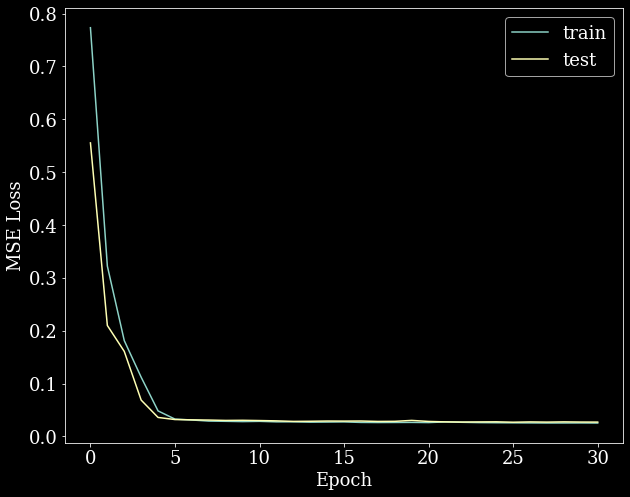

In [8]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

## Signal Reconstruction

... can be done by using the entire model to predict the output spectra. The following code snippet takes a signal (change the index value in the first line to use any other signal) and predicts the Autoencoder based spectrum.

As one can see, the results are "quite ok" but not perfect. The shape of the spectra can be reproduced. However, the signals are quite noisy.

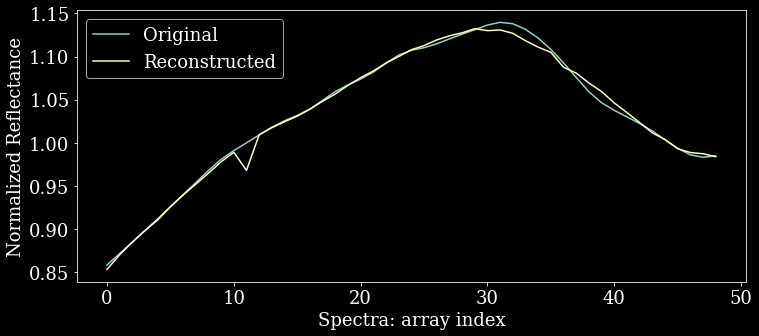

In [9]:
# Which index shall be displayed?
index_val = 5

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

<a id='SessionStart'></a>

In [10]:
# Create dataframe that contains the encoder values (2 values at bottleneck) and the corresponding
# class to see whether the autoencoder values cluster in a way

# Encode the spectra
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=["enc1", "enc2", "Main_Group", "Bus_Class"])

# Change the dtype to float
encoded_df.loc[:, "enc1"] = encoded_df["enc1"].astype(float)
encoded_df.loc[:, "enc2"] = encoded_df["enc2"].astype(float)

SyntaxError: invalid syntax (267677956.py, line 1)

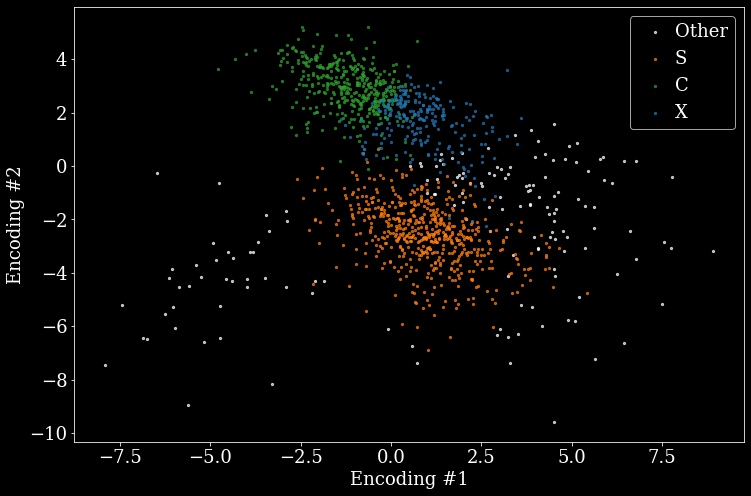

In [11]:
# Plot now the autoencoder values for the Main Group

# Create a dictionary to color the classes
color_dict = {'Other': 'w',
              'S': 'tab:orange',
              'C': 'tab:green',
              'X': 'tab:blue'}

# Set a plot
plt.figure(figsize=(12,8))

# Create a scatter plot with the encoder values and assign the colors to the corresponding classes
for asteroid_class, cluster_color in color_dict.items():
    plt.scatter(encoded_df.loc[encoded_df["Main_Group"] == asteroid_class]["enc1"],
                encoded_df.loc[encoded_df["Main_Group"] == asteroid_class]["enc2"],
                marker='o',
                s=5,
                alpha=0.7,
                color=cluster_color,
                label=asteroid_class)

# Set xlabels
plt.xlabel("Encoding #1")
plt.ylabel("Encoding #2")

plt.legend()

ax = plt.gca()
ax.legend(handletextpad=0.1)

plt.show()

In [14]:
# Let's create now an interactive plot for the Bus Class! Do we see clusters in the Bus-Class
# domain?
%matplotlib inline
import ipywidgets

# In our plot we will plot only the "top 20" Bus Classes (sorted by number)
top_bus = encoded_df.groupby('Bus_Class')['Main_Group'].count().nlargest(20)
bus_classes = sorted(top_bus.index)

# Filter the dataframe
encoded_train_df = encoded_df[encoded_df["Bus_Class"].isin(top_bus.index)].copy()

# Get a list of all Bus Classes
bus_classes = sorted(encoded_df["Bus_Class"].unique())

# Create a Selection widget
# Note: Press Shift or Cntrl (Windows) / CMD (MacOS) to choose multiple classes
selector = ipywidgets.SelectMultiple(options = bus_classes,
                                     value = [bus_classes[0]],
                                     rows = 10,
                                     description = 'Variables',
                                     disabled = False)

# Get the selected items
output = ipywidgets.Output()
display(selector)
display(output)

# Create a colormap, the colors and create a color dictionary
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(bus_classes)))
for k, c in zip(bus_classes, colors):
    color_dict[k] = c

# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Set a function for the (interactive) plots
def plot_encoding(widg):

    # Get the selected choices
    choices = widg['new']

    # Filter the dataframe based on the selection
    data = encoded_df.loc[encoded_df["Bus_Class"].isin(choices)] if choices \
               else encoded_df
    output.clear_output(wait=True)

    with output:

        # Create a "wide screen figure"
        fig, ax = plt.subplots(figsize=(20,8))

        # Plot the encoding values within a for loop to create easily a legend for each group
        for bus_k in np.unique(data["Bus_Class"]):

            ax.scatter(data.loc[data["Bus_Class"] == bus_k]["enc1"],
                       data.loc[data["Bus_Class"] == bus_k]["enc2"],
                       marker = 'o',
                       s = 15,
                       alpha = 0.7,
                       color = color_dict.get(bus_k),
                       label = bus_k)

        # Create the legend
        ax.legend()

        # Set labels
        plt.xlabel("Encoding #1")
        plt.ylabel("Encoding #2")

        # Set limits
        plt.xlim(np.min(encoded_df["enc1"]), np.max(encoded_df["enc1"]))
        plt.ylim(np.min(encoded_df["enc2"]), np.max(encoded_df["enc2"]))

        plt.show()

# Create an interactive session!
selector.observe(plot_encoding, names='value')

SelectMultiple(description='Variables', index=(0,), options=('A', 'B', 'C', 'Cb', 'Cg', 'Cgh', 'Ch', 'D', 'K',…

Output()